In [36]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [37]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [93]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [94]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [95]:
X_train = X_train.float()
X_test = X_test.float()

In [96]:
X_train.shape, X_test.shape


(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [97]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

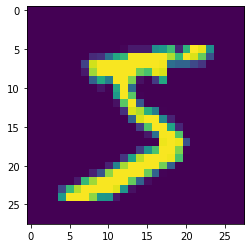

tensor(5)


In [98]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [99]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])


In [105]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_net.parameters(), lr=1.0e-3, momentum = 0.9)

In [106]:
torch.cuda.is_available()

True

In [107]:
!nvidia-smi

Mon Sep 12 20:33:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    29W /  70W |   1178MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [108]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0102, -0.0242,  0.0206,  ...,  0.0196,  0.0238,  0.0027],
         [ 0.0256,  0.0321, -0.0212,  ..., -0.0263, -0.0031,  0.0042],
         [ 0.0209,  0.0131, -0.0232,  ...,  0.0327,  0.0046, -0.0244],
         ...,
         [-0.0188, -0.0284, -0.0048,  ..., -0.0293, -0.0023, -0.0132],
         [ 0.0168, -0.0352, -0.0041,  ..., -0.0314, -0.0040,  0.0095],
         [ 0.0142,  0.0138,  0.0024,  ..., -0.0076,  0.0211,  0.0103]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 0.0317,  0.0245, -0.0060, -0.0350,  0.0309,  0.0349,  0.0308,  0.0307,
         -0.0173,  0.0234, -0.0309, -0.0184, -0.0288,  0.0225, -0.0277, -0.0068,
          0.0263, -0.0117, -0.0219,  0.0210, -0.0040,  0.0115, -0.0080, -0.0344,
          0.0149, -0.0343, -0.0326, -0.0246, -0.0070, -0.0237,  0.0310,  0.0318,
          0.0165,  0.0124, -0.0207, -0.0094,  0.0312,  0.0304,  0.0272,  0.0107,
         -0.0115, -0.0343,  0.0105,  0.0176,  0.0078, -0.0201, 

In [109]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).detach().cpu().numpy())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy.cpu())
    print(accuracy)

tensor(0.8949, device='cuda:0')
tensor(0.9157, device='cuda:0')
tensor(0.9233, device='cuda:0')
tensor(0.9263, device='cuda:0')
tensor(0.9312, device='cuda:0')
tensor(0.9359, device='cuda:0')
tensor(0.9374, device='cuda:0')
tensor(0.9399, device='cuda:0')
tensor(0.9429, device='cuda:0')
tensor(0.9451, device='cuda:0')
tensor(0.9475, device='cuda:0')
tensor(0.9442, device='cuda:0')
tensor(0.9489, device='cuda:0')
tensor(0.9487, device='cuda:0')
tensor(0.9491, device='cuda:0')
tensor(0.9523, device='cuda:0')
tensor(0.9508, device='cuda:0')
tensor(0.9536, device='cuda:0')
tensor(0.9532, device='cuda:0')
tensor(0.9529, device='cuda:0')
tensor(0.9535, device='cuda:0')
tensor(0.9541, device='cuda:0')
tensor(0.9564, device='cuda:0')
tensor(0.9554, device='cuda:0')
tensor(0.9533, device='cuda:0')
tensor(0.9565, device='cuda:0')
tensor(0.9578, device='cuda:0')
tensor(0.9576, device='cuda:0')


KeyboardInterrupt: ignored

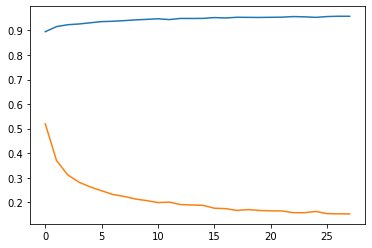

In [110]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history)